## Intro

Having trained several models trained on several different data distributions, let's plot their performace throughout the manifold, and compare to the ground truth function.

This notebook examines logspace_near_peak, which aims to capture the jump in $\phi$ and the crease in $\log A$ best.

Let's load the python modules and the model, first.

In [1]:
from utils import *
from datafile import *
from betaVAE import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'logspace_near_peak'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])
ln=True

L = get_loss(fname)

model = get_model(fname)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB,ln

[0.01, 5, 2048, 0.0001, 50000, 0.0, -4.605170185988091, 1.0, 1.0]


## Learning

First, let's take a look at the learning curve, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

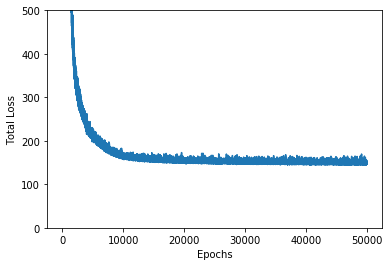

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(L)+1), L)
plt.ylim([0, 500])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")

fig

It appears that the overall loss has plateaued around

In [3]:
print(L[-10:])

[147.94508361816406, 149.05604553222656, 147.3406219482422, 149.13223266601562, 148.86451721191406, 145.83334350585938, 152.7648162841797, 145.71243286132812, 146.6152801513672, 150.03016662597656]


## Behavior on Training Data; Metrics

Now that we see that the network is fully trained, let's look at several metrics of its performance on the domain where it was trained.

Let's take a look at the data itself, first.

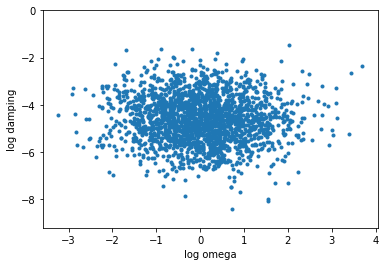

In [6]:
data, groundTruth = log_datagen(muW, muB, stdW, stdB, datasize)

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlabel("log omega")
plt.ylabel("log damping")
plt.ylim([np.log(0.0001), np.log(1)])
#plt.xlim([np.log(0.2), np.log(5.0)])

fig

Now, let's compute the network's output on this data, and then compute some metrics.

In [7]:
d = torch.FloatTensor(data).cuda()

o, mu, _ = model(d)

output = o.cpu().detach().numpy()
means = mu.cpu().detach().numpy()

In [8]:
errors = output - groundTruth

phaseE = errors[:, 0]
ampE = errors[:, 1]

print(errors)

[[ 0.0061383   0.01458767]
 [-0.02232301  0.00663435]
 [-0.00471284 -0.01497129]
 ...
 [-0.01185619 -0.02169329]
 [-0.01233669 -0.01022734]
 [ 0.00692793 -0.01066573]]


In [9]:
phases = groundTruth[:, 0]
amps = groundTruth[:, 1]

prange = max(phases) - min(phases)
arange = max(amps) - min(amps)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(phaseE**2))
typicalae = np.sqrt(np.mean(ampE**2))

print("Typical Phase Error")
print(typicalpe)
print("Typical Amp Error")
print(typicalae)

print("Typical phase error / phase range")
print(typicalpe/prange)
print("Typical amp error / amp range")
print(typicalae/arange)

Typical Phase Error
0.03289259919528789
Typical Amp Error
0.019259912614491663
Typical phase error / phase range
0.010471355226165208
Typical amp error / amp range
0.0015300843473715672


So far, so good. We see the typical error on the data distribution the network was trained on. Later on, we'll also examine how the latent space was used using "means," but for now, let's try to fully understand how well this network understands the underlying function.

## Plots of The Function

### Behavior Near Training Distribution

To begin with, we will plot the groundTruth and the network approximation within the domain where it was trained ($mu \pm 2\sigma $), as well as a distribution of the errors.

In [3]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


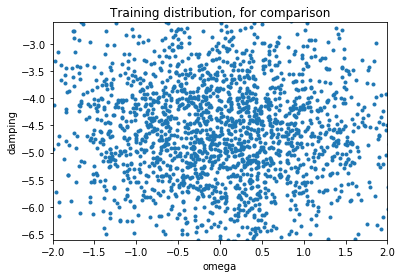

In [11]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [4]:
# Compute the ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

In [5]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

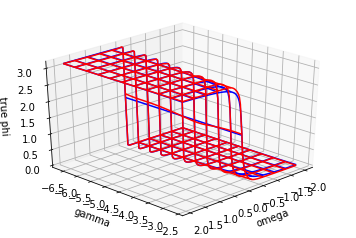

In [14]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 45)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")


fig

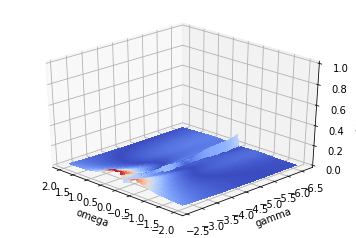

In [15]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

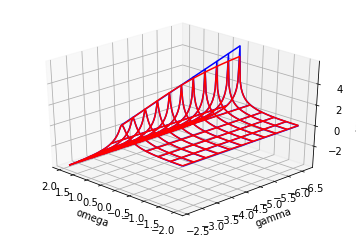

In [16]:
# Plot A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
#ax.set_zlim(0, 1)

fig

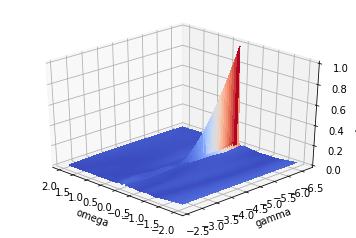

In [17]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

### Behavior away from the training distribution

Alright. Now how does the model perform well outside of its original domain?

Specifically for this model, we are in a slightly difficult position because the training area covers most of the range of values we normally care about, but we can test for artefacts by simply increasing the window size artificially.

In [6]:
# Make the data

wmin = muW - 6*stdW
wmax = muW + 6*stdW
wstep = (wmax - wmin)/100

bmin = muB - 6*stdB
bmax = 0.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


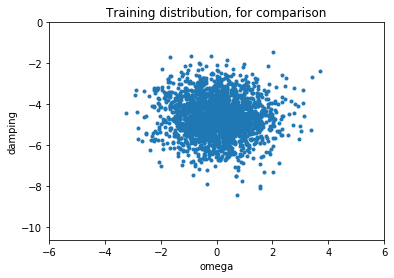

In [19]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [7]:
# Compute the ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

In [8]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

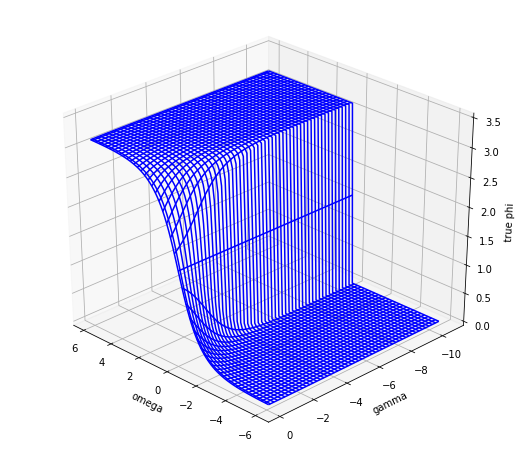

In [10]:
# Plot Phi, true and modeled

fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
#surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")
ax.set_zlim(0, 3.5)

fig

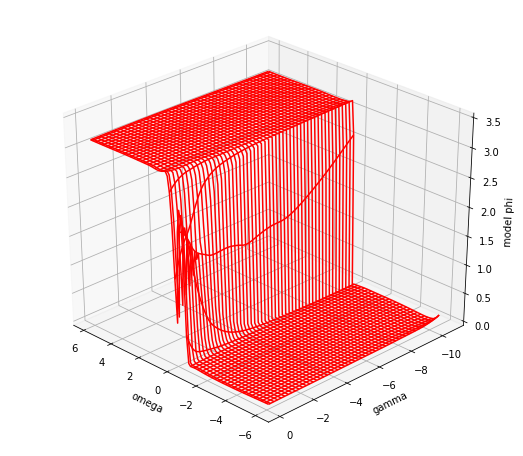

In [11]:
# Plot Phi, true and modeled

fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

#surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("model phi")
ax.set_zlim(0, 3.5)

fig

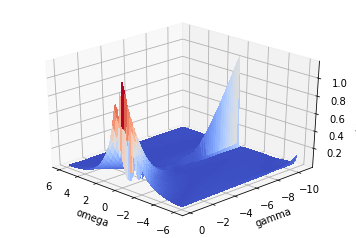

In [27]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")

fig

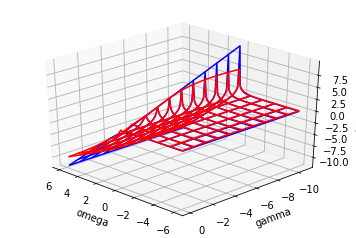

In [28]:
# Plot Ground Truth A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
#ax.set_zlim([0, 5])

fig

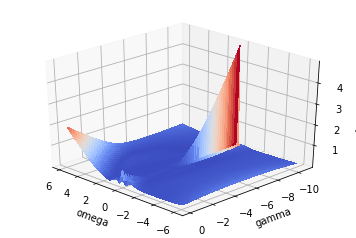

In [29]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
#ax.set_zlim([0, 5])

fig

Now that we are looking at the extrapolation potential of the system, let's take a look at the extremes.

In [30]:
print("Max predicted phase")
print(max(modelPhi.reshape((10000,))))
print("Min predicted phase")
print(min(modelPhi.reshape((10000,))))
print("Max predicted amplitude")
print(max(modelA.reshape((10000,))))
print("Min predicted amplitude")
print(min(modelA.reshape((10000,))))

print("\n\n")

print("Max true phase")
print(max(Phi.reshape((10000,))))
print("Min true phase")
print(min(Phi.reshape((10000,))))
print("Max true amplitude")
print(max(A.reshape((10000,))))
print("Min true amplitude")
print(min(A.reshape((10000,))))

Max predicted phase
3.184938
Min predicted phase
-0.027586978
Max predicted amplitude
5.161928
Min predicted amplitude
-11.618994



Max true phase
3.1415925150371096
Min true phase
1.2288500209811168e-07
Max true amplitude
9.91202300542814
Min true amplitude
-11.760004825238761


## Latent Space

Let's now look at the latent dimensions. Let's first see which are used at all during validation.

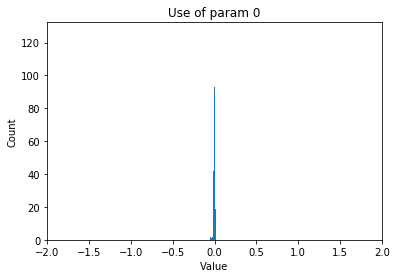

In [31]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 0], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 0")
fig

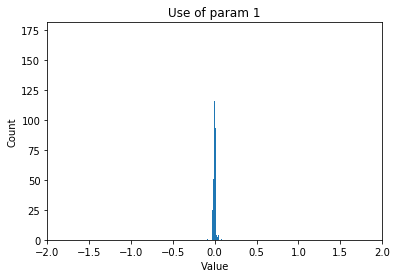

In [32]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 1], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 1")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


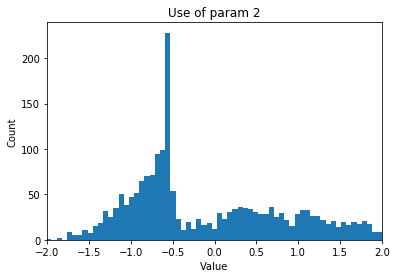

In [33]:
# Param 2

fig = plt.figure()
plt.hist(means[:, 2], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 2")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


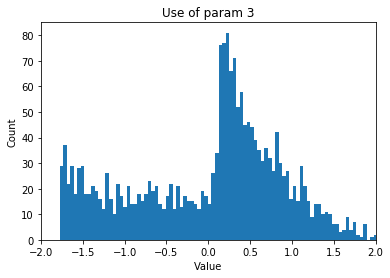

In [34]:
# Param 3

fig = plt.figure()
plt.hist(means[:, 3], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 3")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


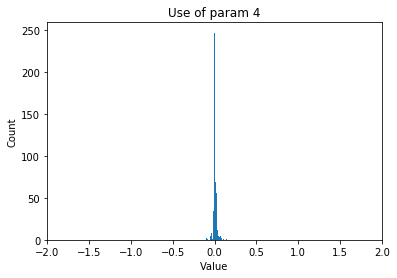

In [35]:
# Param 4

fig = plt.figure()
plt.hist(means[:, 4], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 4")
fig

It seems that, during evaluation, only parameters $2$ and $3$ are used - even if it seems like the distribution is not quite a univariate normal.

Let's plot their dependence on $\omega$ and $\gamma$ within the training distribution.

In [36]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


In [37]:
# Compute param values

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, params, _ = model(gridpoints)

npm = params.cpu().detach().numpy()
npo = output.cpu().detach().numpy()

param2 = npm[:, 2].reshape(100, 100)
param3 = npm[:, 3].reshape(100, 100)

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


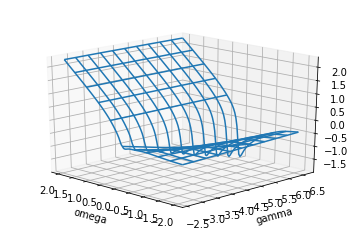

In [41]:
# Plot param 2

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param2, rstride=10, cstride=10)
ax.view_init(20, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param2")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


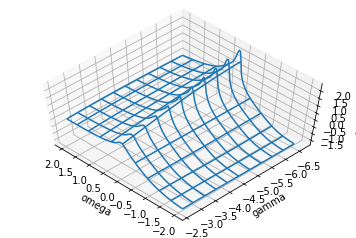

In [40]:
# Plot param 3

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param3, rstride=10, cstride=10)
ax.view_init(60, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

In [43]:
# Compute ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


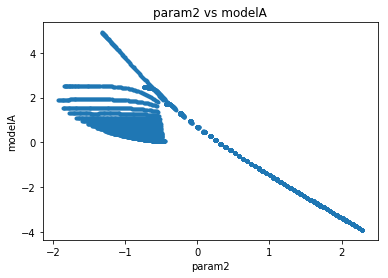

In [42]:
# Compare modelA and param2

fig = plt.figure()
plt.scatter(param2, modelA, marker='.')
plt.title("param2 vs modelA")
plt.xlabel("param2")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


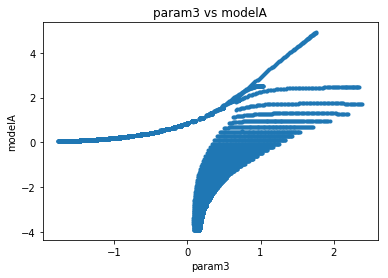

In [43]:
# Compare modelA and param3

fig = plt.figure()
plt.scatter(param3, modelA, marker='.')
plt.title("param3 vs modelA")
plt.xlabel("param3")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


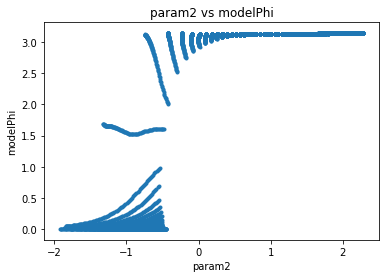

In [44]:
# Compare modelPhi and param2

fig = plt.figure()
plt.scatter(param2, modelPhi, marker='.')
plt.title("param2 vs modelPhi")
plt.xlabel("param2")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


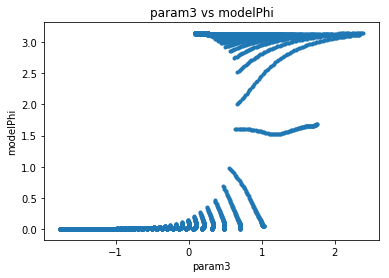

In [45]:
# Compare modelPhi and param3

fig = plt.figure()
plt.scatter(param3, modelPhi, marker='.')
plt.title("param3 vs modelPhi")
plt.xlabel("param3")
plt.ylabel("modelPhi")
fig

## Concluding Thoughts

This network performed almost as admirably as lospace_broad. The main new mistake was a failure to model the less sharp portion of the $\phi$ function, but that was entirely out of domain. Also, the latent space was even further from a normal, and predict the output even more poorly, although only $2$ latent variables were used.

In short, using log coordinates consistently improves performance when difficult features are present, but this problem is still very far from the best one for SciNet. Let's see if this thesis holds up on the last logspace network, logspace_near_peak_narrow.